In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from util import process_file
from typing import Type
from peak_shave_sim import PeakShaveSim
from peak_shave_sim import ConstLimPeakShaveSim
from peak_shave_sim import DynamicLimPeakShaveSim
from peak_shave_sim import EqualizedLimPeakShaveSim
from greedy import GreedySim

FILENAME = '../data/Sub71125.csv'
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 600

In [13]:
liion_cnt = 3
flywh_cnt = 3
sucap_cnt = 3
margin = .05
lookahead = 24

In [14]:
df = process_file(FILENAME)
config = {
    'delta_limit': 1,
    'LiIonBattery': liion_cnt,
    'Flywheel': flywh_cnt,
    'Supercapacitor': sucap_cnt
}

In [15]:
def get_powers(SimClass: Type[PeakShaveSim], config: dict,
               df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    sim = SimClass(config, df)
    _, _, powers = sim.run(**kwargs)
    columns = None
    limit_mode = (len(powers[0]) == 6)
    if limit_mode:
        columns = ['timestamp', 'pnet', 'pbought', 'soc', 'lower', 'upper']
    else:
        columns = ['timestamp', 'pnet', 'pbought', 'soc']
    powers = pd.DataFrame(powers, columns=columns)
    return powers


In [16]:
powers_dict = dict()
powers_dict[ConstLimPeakShaveSim] = get_powers(ConstLimPeakShaveSim, config, df, margin=margin, penalize_charging=True, create_log=True)
powers_dict[DynamicLimPeakShaveSim] = get_powers(DynamicLimPeakShaveSim, config, df, margin=margin, lookahead=lookahead, penalize_charging=True, create_log=True)
powers_dict[EqualizedLimPeakShaveSim] = get_powers(EqualizedLimPeakShaveSim, config, df, lookahead=lookahead, penalize_charging=True, create_log=True)
powers_dict[GreedySim] = get_powers(GreedySim, config, df, penalize_charging=True, create_log=True)

batteries.py: EnergyHub initialized with config: {'delta_limit': 1, 'LiIonBattery': 3, 'Flywheel': 3, 'Supercapacitor': 3}
batteries.py: EnergyHub initialized with config: {'delta_limit': 1, 'LiIonBattery': 3, 'Flywheel': 3, 'Supercapacitor': 3}
batteries.py: EnergyHub initialized with config: {'delta_limit': 1, 'LiIonBattery': 3, 'Flywheel': 3, 'Supercapacitor': 3}
batteries.py: EnergyHub initialized with config: {'delta_limit': 1, 'LiIonBattery': 3, 'Flywheel': 3, 'Supercapacitor': 3}


/tmp/ipykernel_439/3930134454.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticks(), rotation=45)
/tmp/ipykernel_439/3930134454.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticks(), rotation=45)
/tmp/ipykernel_439/3930134454.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticks(), rotation=45)
/tmp/ipykernel_439/3930134454.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticks(), rotation=45)


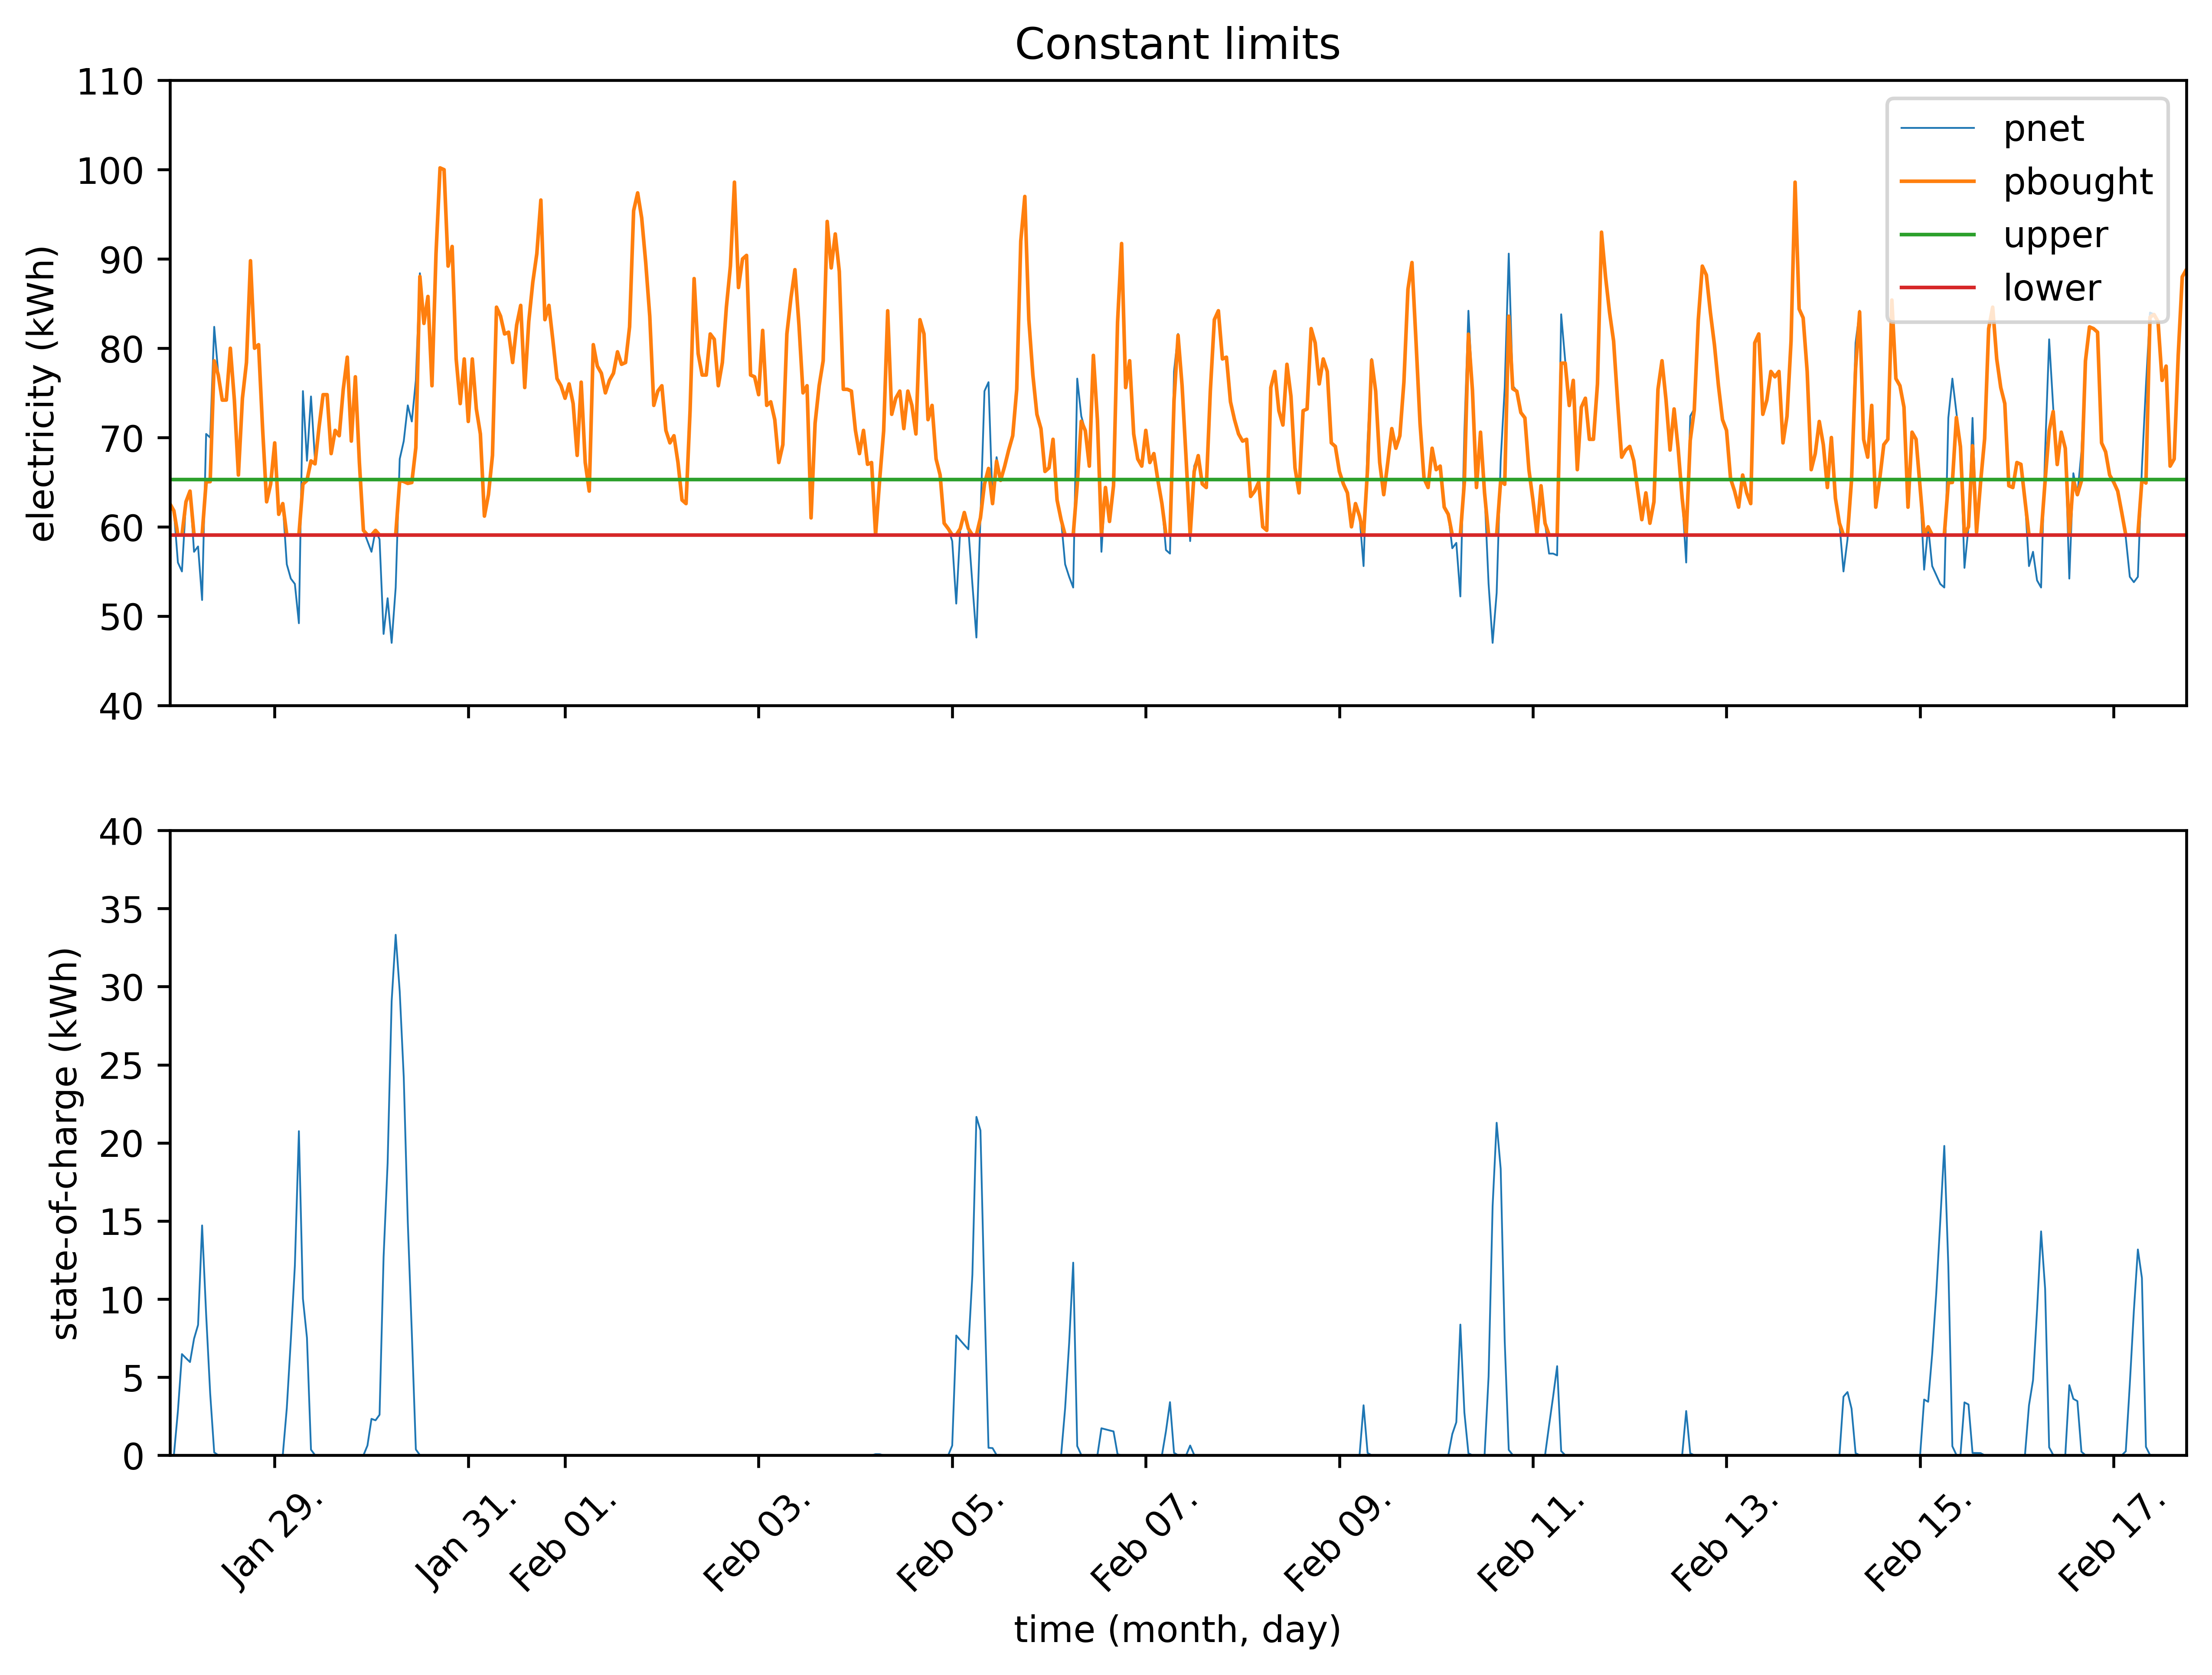

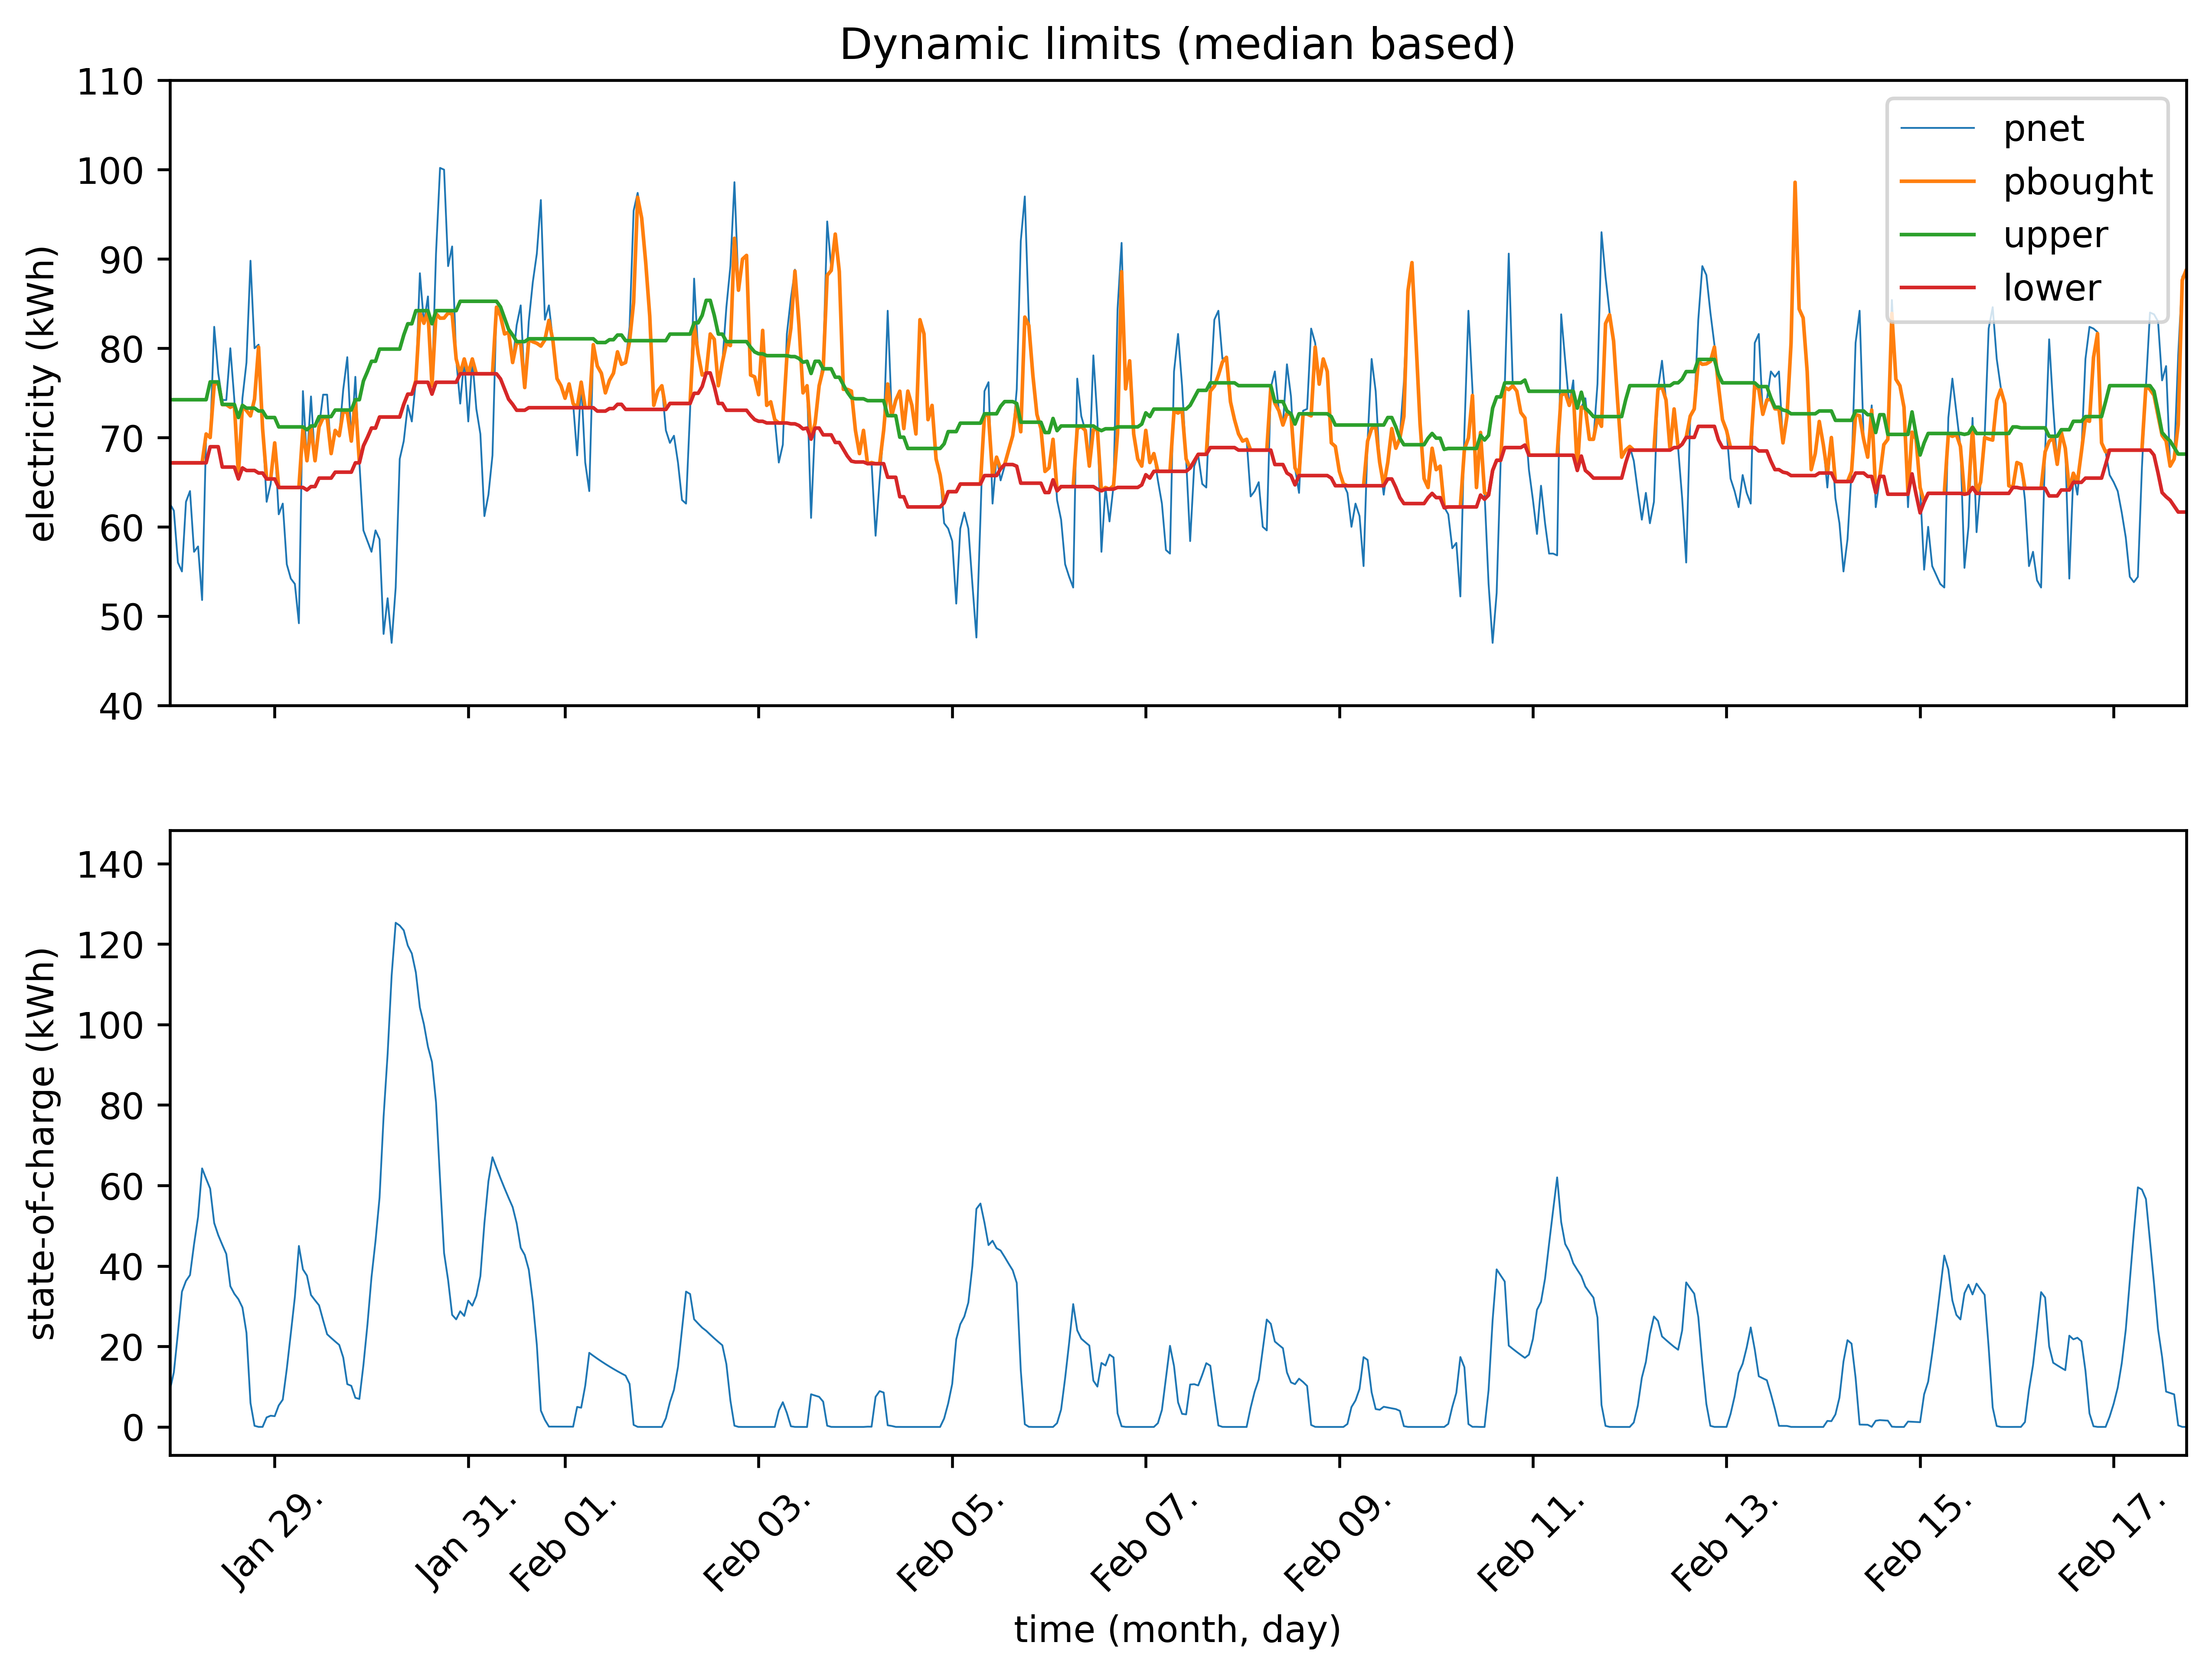

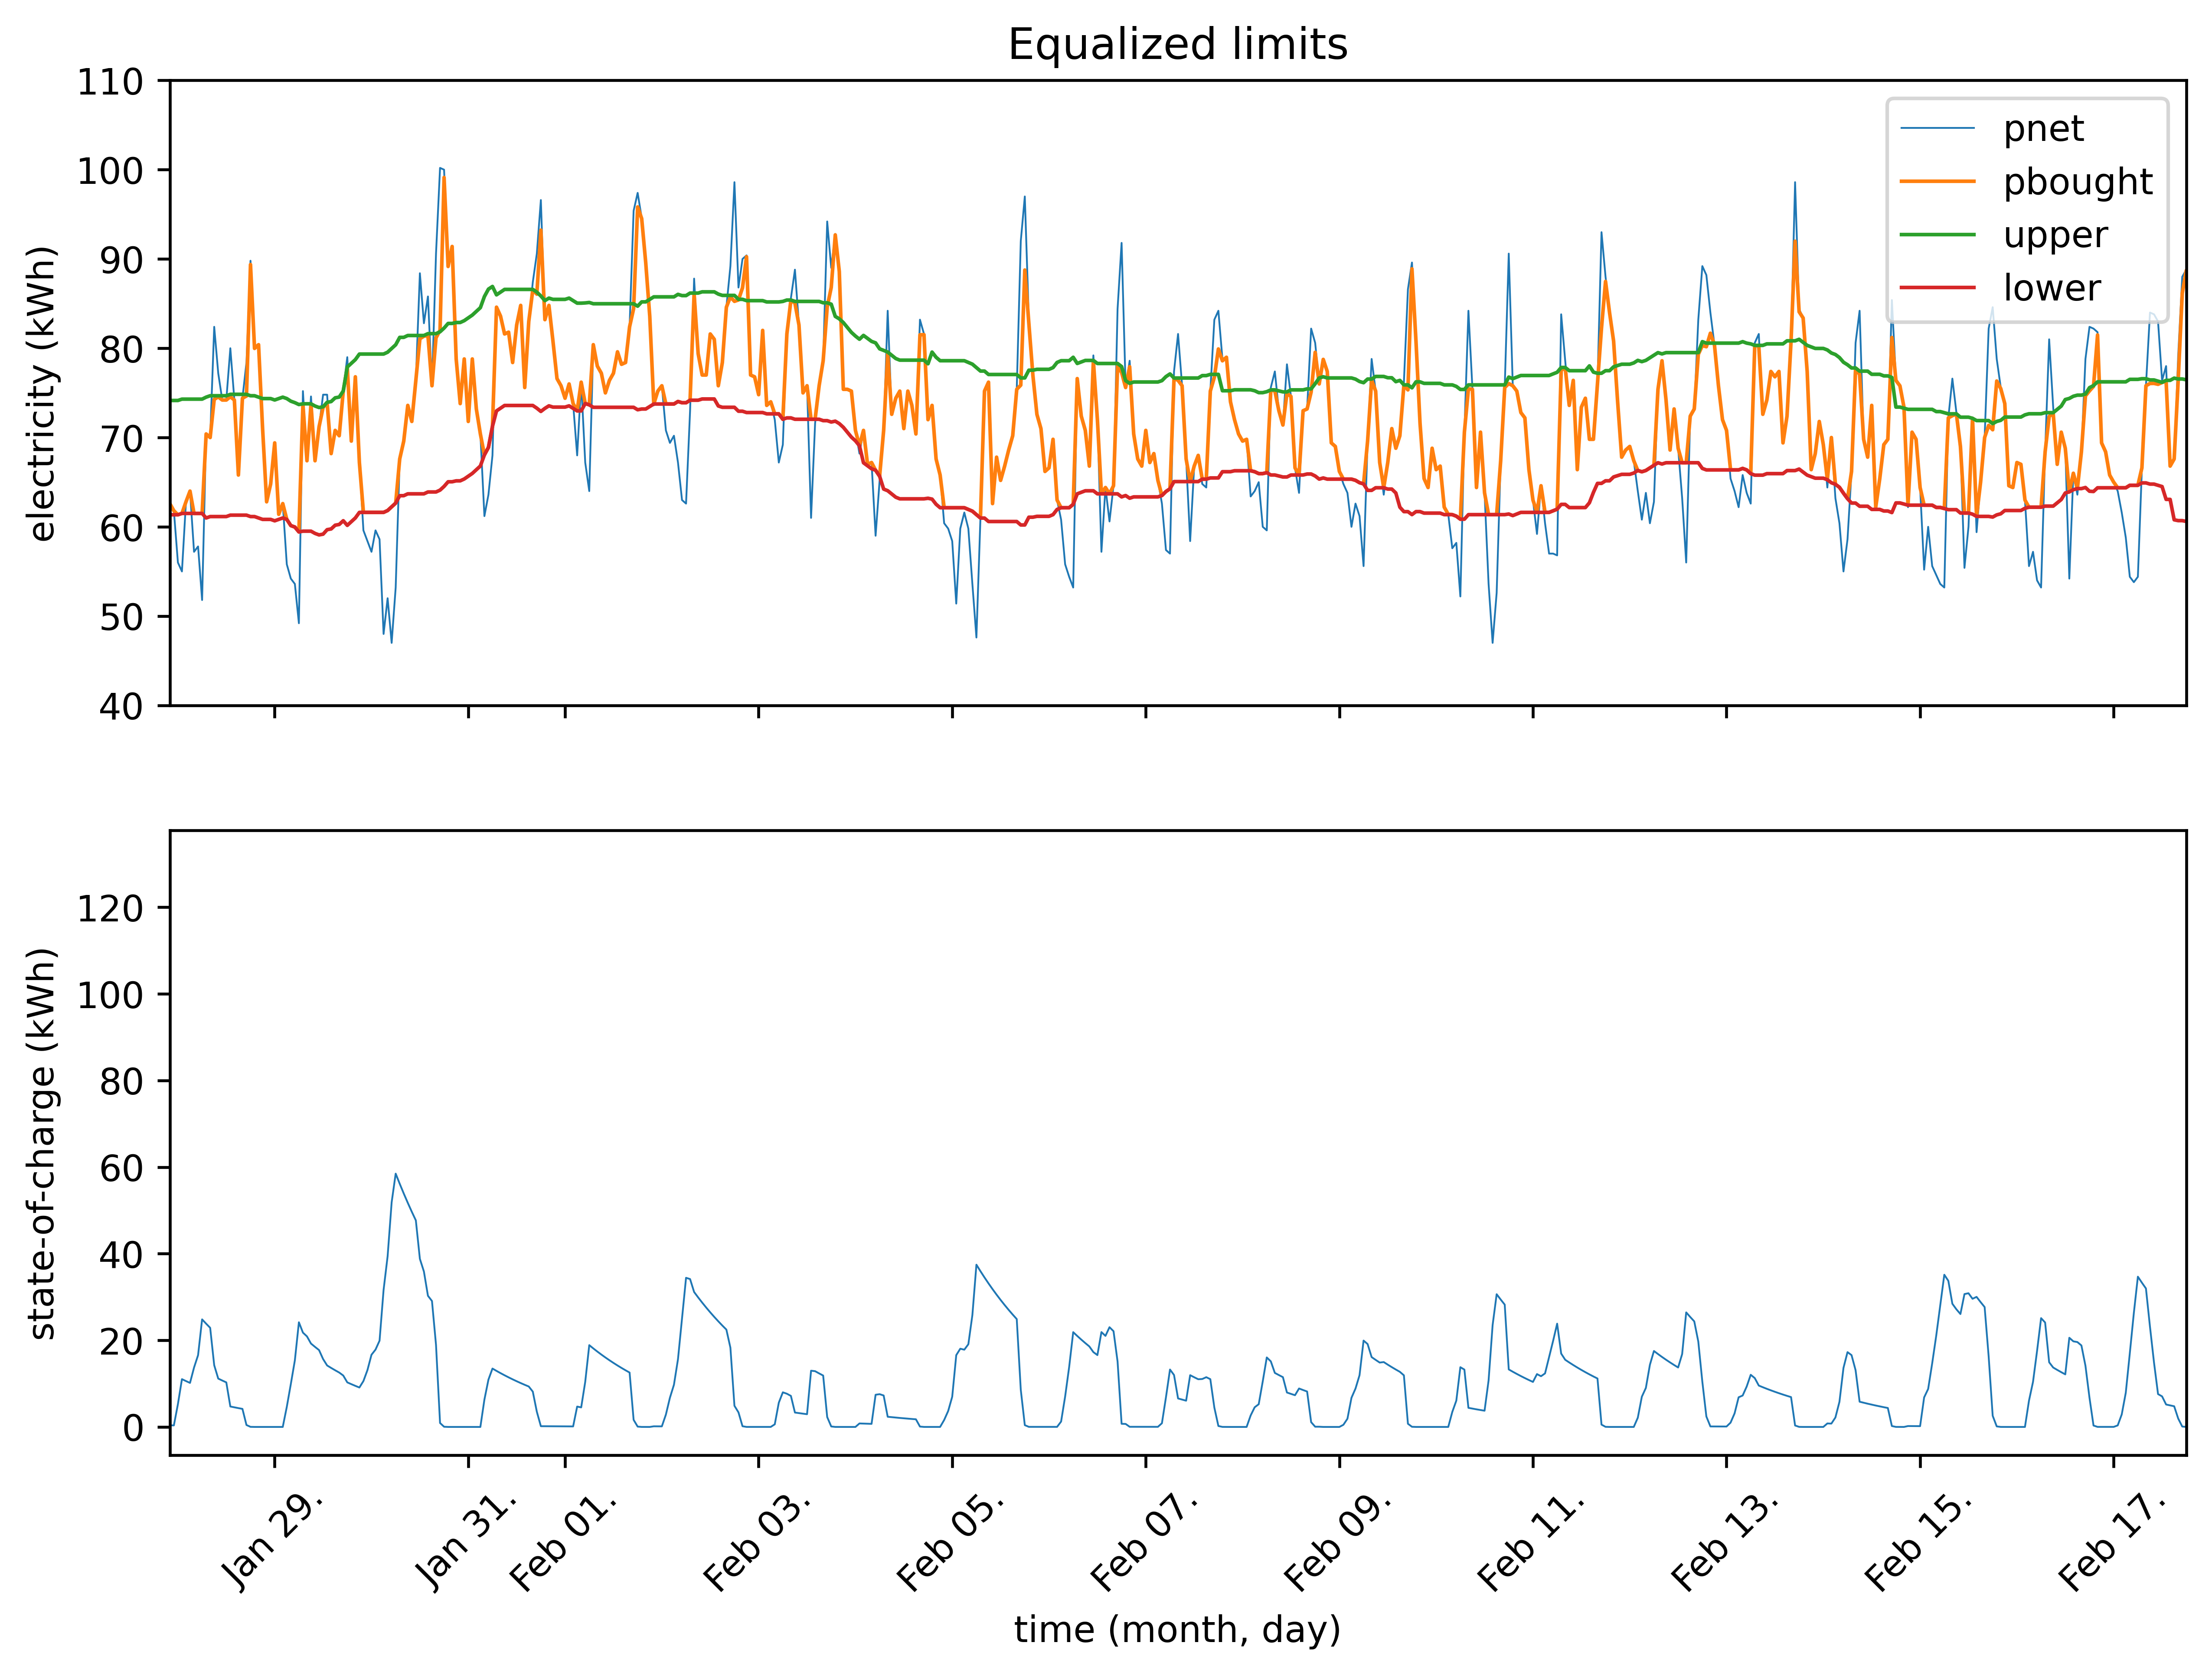

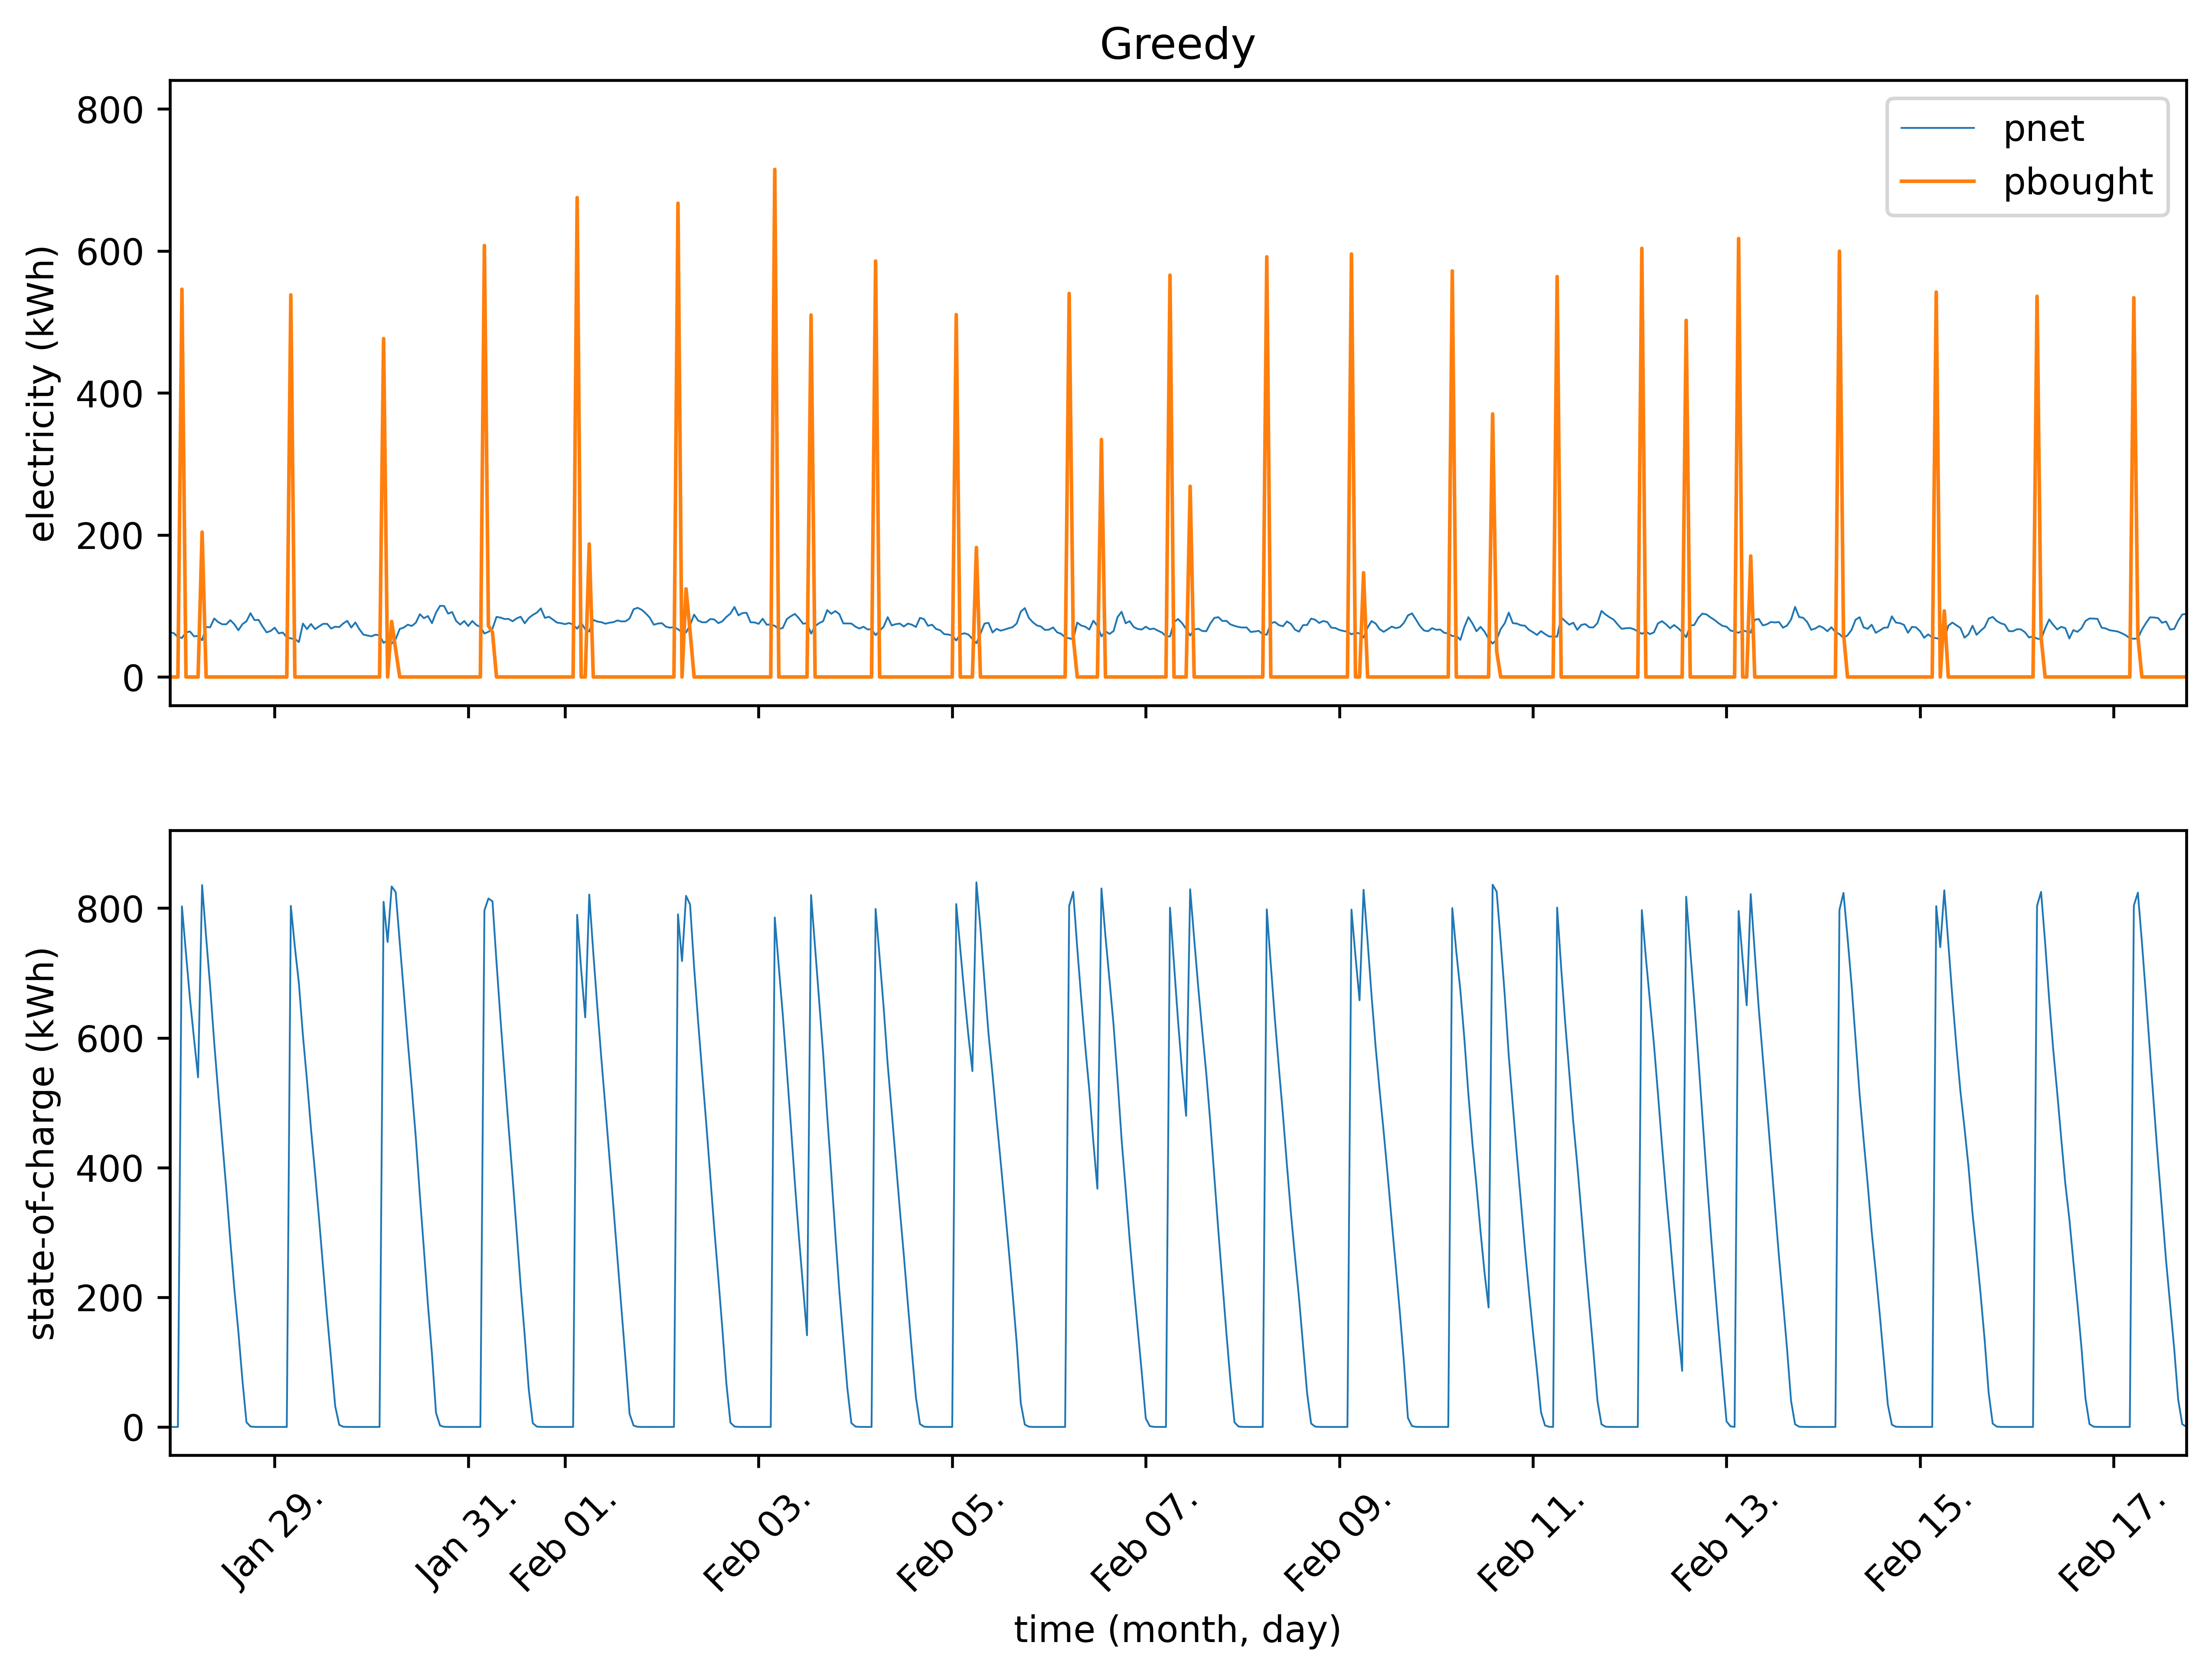

In [34]:
def plot(SimClass: Type[PeakShaveSim], powers: pd.DataFrame) -> None:

    _, axes = plt.subplots(2, 1, sharex=True)

    axes[0].plot(powers['timestamp'], powers['pnet'], linewidth=.5, label='pnet')
    axes[0].plot(powers['timestamp'], powers['pbought'], linewidth=1, label='pbought')
    if 'upper' in powers.columns:
        axes[0].plot(powers['timestamp'], powers['upper'], linewidth=1, label='upper')
        axes[0].plot(powers['timestamp'], powers['lower'], linewidth=1, label='lower')
    axes[1].plot(powers['timestamp'], powers['soc'], linewidth=.5)

    start = powers.iloc[2500]['timestamp']
    end = powers.iloc[3000]['timestamp']
    plt.xlim(start, end)

    axes[0].legend(loc='upper right')

    if SimClass == ConstLimPeakShaveSim:
        axes[0].set_title('Constant limits')
        axes[1].set_ylim(0, 40)
        axes[0].set_ylim(40, 110)
    elif SimClass == DynamicLimPeakShaveSim:
        axes[0].set_title('Dynamic limits (median based)')
        axes[0].set_ylim(40, 110)
    elif SimClass == EqualizedLimPeakShaveSim:
        axes[0].set_title('Equalized limits')
        axes[0].set_ylim(40, 110)
    elif SimClass == GreedySim:
        axes[0].set_title('Greedy')

    axes[0].set_ylabel('electricity (kWh)')
    axes[1].set_ylabel('state-of-charge (kWh)')
    axes[1].set_xlabel('time (month, day)')

    axes[1].set_xticklabels(axes[1].get_xticks(), rotation=45)
    fmt = DateFormatter('%b %d.')
    axes[1].xaxis.set_major_formatter(fmt)

    plt.savefig(SimClass.__name__ + '.png', dpi=600, format='png', facecolor='white', transparent=False)

for k, v in powers_dict.items():
    plot(k, v)